In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import os
import sys
from ocp_table_tpot.globals import Globals as gd
from tpot import TPOTRegressor
sys.path.insert(0,'..')
from src.models.model import HistoricalMedian,XGBoost,LinearModel,RF,KNN,SVM,mase,TimeSeriesSplitImproved
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC,RANSACRegressor
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor,ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler,MinMaxScaler,PolynomialFeatures,StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split,cross_val_predict
from skgarden.quantile import RandomForestQuantileRegressor
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.preprocessing import FunctionTransformer

from copy import copy
from tpot.builtins import StackingEstimator
from lightgbm import LGBMRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.pipeline import make_pipeline, make_union
from catboost import CatBoostRegressor,Pool,cv
sys.path.insert(0,'..')
from src.models.model import HistoricalMedian,XGBoost,LinearModel,RF,KNN,SVM,mase
from src.data.make_dataset import DROPCOLS
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

Using TensorFlow backend.


## Load data

In [2]:
df_tsfresh = pd.read_pickle(f'../data/processed/train_test_tsfresh.pkl').reset_index(level = 0)
data_dict = pd.read_pickle(f'../data/processed/data_dict_all.pkl')

In [3]:
# For Final 
tgt = 'final.output.recovery'

year = 2019
X = data_dict[year]['X_train'].astype(float).drop(DROPCOLS,axis = 1)
y = data_dict[year]['y_train'].astype(float)
# Add Lags:
mask_weights = ((y[tgt] > 41) & (y[tgt] < 100))
print(f'X = {X.shape} y = {y.shape}')
print(f'DROPNA X = {X.dropna().shape} DROPNA y = {y[tgt].dropna().shape}')


X = (16860, 65) y = (16860, 7)
DROPNA X = (16860, 65) DROPNA y = (15339,)


## Prepare the windowed data

In [4]:
# window_step = 24 # in hours
# window_overlap = 12 # in hours
# Xm = X.values
# i=1
# st = window_step - window_overlap)
# window = Xm[window_step*(i):window_step*(i+1),].reshape(1,24,65)

def cut_cycle(data_cycle, overlap = 0.8, base_length = 150):
    step = int((1-overlap) * base_length)
    n_windows = np.ceil( (data_cycle.shape[0] - base_length)/step)
    indexer = np.arange(base_length)[None, :] + step * np.arange( n_windows )[:, None]
    return indexer.astype('int'), int(n_windows)
def produce_training_data(X,y,tgt = 'final.output.recovery',ov=0.9):
    
    a,b = cut_cycle(y,overlap = ov,base_length=24)
    Xwind = X[a,:]
    ywind = y.iloc[a[:,-1],]
    mask_weights = ((y[tgt] > 41) & (y[tgt] < 100))
    maskwind = mask_weights.iloc[a[:,-1],]
    ywind["mask"] = maskwind
    return Xwind,ywind


# Keras NNet solution

In [5]:
# bagging mlp ensemble on blobs dataset
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
from sklearn.datasets.samples_generator import make_blobs
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam,SGD
from keras.initializers import random_uniform,glorot_uniform
from keras.layers import Dense,Dropout,BatchNormalization,Activation,Conv1D,MaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint,Callback
from keras.wrappers.scikit_learn import KerasRegressor
import keras.backend as K
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from matplotlib import pyplot
from numpy import mean
from numpy import std
import numpy
from numpy import array
from numpy import argmax
from keras_tqdm import TQDMNotebookCallback
import numpy as np
import tensorflow as tf

def huber_loss(y_true, y_pred, clip_delta=1.0):
  error = y_true - y_pred
  cond  = tf.keras.backend.abs(error) < clip_delta

  squared_loss = 0.5 * tf.keras.backend.square(error)
  linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)

  return tf.where(cond, squared_loss, linear_loss)

def tilted_loss( y, f,q = 0.55):
    e = (y - f)
    return K.mean(K.maximum(q * e, (q - 1) * e),
                              axis=-1)

def huber_loss_mean(y_true, y_pred, clip_delta=1.0):
  return tf.keras.backend.mean(huber_loss(y_true, y_pred, clip_delta))

def create_model(optimizer=Adam(lr=0.01),
                 kernel_initializer=random_uniform(seed=12), 
                 dropout=0.1,TIME_PERIODS = 24,num_channels = 65):
    
    model = Sequential()
    model.add(Conv1D(32, 2, activation='relu', input_shape=(TIME_PERIODS, num_channels),padding = 'same',strides = 1))
  #  model.add(Conv1D(32, 2, activation='relu',padding = 'same',strides = 1))
    model.add(MaxPooling1D(3))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu',kernel_initializer=kernel_initializer))
    model.add(Dropout(dropout))
    model.add(Dense(1,kernel_initializer=kernel_initializer))

    model.compile(loss=huber_loss,optimizer=optimizer, metrics=['mae'])

    return model
# wrap the model using the function you created
reg = KerasRegressor(build_fn=create_model,verbose=0)


scaler = make_pipeline(QuantileTransformer(output_distribution='normal'),StandardScaler(),PCA(whiten=True))
target_scaler = make_pipeline(QuantileTransformer(output_distribution='normal'),StandardScaler())


callbacks = [EarlyStopping(monitor='val_loss', patience=6),TQDMNotebookCallback(leave_inner=False),
             ModelCheckpoint(filepath='./keras-ch/best_model.h5', monitor='val_loss', save_best_only=True)]

C:\Users\abiryukov\AppData\Local\Continuum\anaconda3\envs\ocp\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\abiryukov\AppData\Local\Continuum\anaconda3\envs\ocp\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


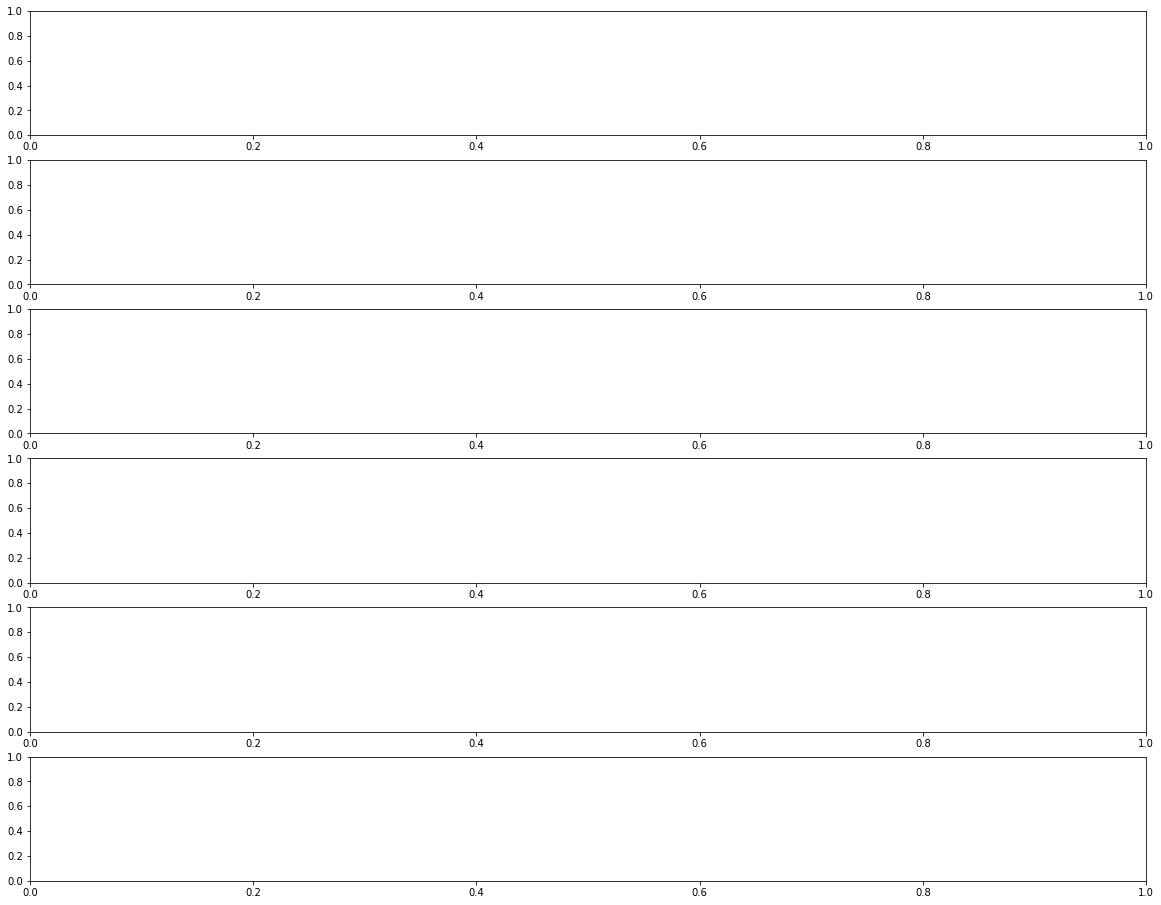

In [7]:
n_folds = 6
cv = KFold(n_folds, shuffle=False, random_state=42)
model = reg
scores = []
preds_all_alt = np.empty_like(y)
preds_all_base = np.empty_like(y)



true_all =np.empty_like(y)
fig,ax = plt.subplots(figsize = (20,16),nrows = n_folds)
X_new = scaler.fit_transform(X)
Xw,yw = produce_training_data(X_new,y,ov=0.5)
mask = yw['mask'].values
yw[tgt] = yw[tgt].fillna(method='bfill')
yf = yw[tgt].values


In [ ]:
history = [None for i in range(n_folds)]

for fold_n, (train_index, valid_index) in enumerate(cv.split(yf)):
# print('Fold', fold_n, 'started at', time.ctime())
    print(train_index)
    X_train, X_valid = Xw[train_index,:,:], Xw[valid_index,:,:]
    y_train, y_valid = yf[train_index], yf[valid_index]
    # Do the base
    params = {"validation_data":(X_valid, y_valid),
             "epochs":30,
             "verbose":0,
             "batch_size":8,
             "callbacks":callbacks}
    model = KerasRegressor(build_fn=create_model,verbose=0)
    history[fold_n] = model.fit(X_train,y_train,**params)
    preds  = model.predict(X_valid)
    preds_all_base[valid_index] = preds
    true_all[valid_index] = y_valid
    score_val = mase(preds,y_valid)
    df = pd.DataFrame({"preds":preds,"true":y_valid})
    df.plot(ax=ax[fold_n],style =['-o','-o','-o'],title =f'CV score base: {score_val:.4f}',markersize=1.5)
    
oof_scores = mase(preds_all_base,true_all)
print(oof_scores)

[ 234  235  236 ... 1400 1401 1402]


# Stack Keras Models